In [2]:
import numpy as np
import matplotlib.pyplot as plt

# Le rapport de classification de scikit-learn

Un petit aide-mémoire à propos du rapport de classification de scikit-learn agrémenté de quelques reflexions méta-statistiques sur la façon de juger de la performance des modèles de classification.

Principale source bibliographique :
- [le user guide de scikit-learn](https://scikit-learn.org/stable/modules/model_evaluation.html#classification-metrics) : ne pas hésiter à s'y reporter pour approfondir les notions que j'aborderai ici
- [un article wikipedia sur le MCC](https://en.wikipedia.org/wiki/Phi_coefficient) : avec des considérations plus générales que le seulement ledit coefficient
- [un article célèbre donnant 10 astuces de ML](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5721660/) écrit à l'origine pour la "biologie assistée par ordinateur" mais facilement transposable à de nombreux domaines

## 1. Données et modèles fictifs

La visée première de ce notebook ne se veut pas réellement pédagogique. Je décide donc de commencer par le cas relativement général de la **classification multi-classe** que je considère comme une aggrégation de classifications binaires. L'idée est que si l'on doit classer une observation entre trois classes A, B et C, on peut se ramener aux trois problèmes qui consistent à savoir si l'observation appartient oui ou non à la classe A, à la classe B et à la classe C.

### 1.1 Une digression d'emblée sur les différences entre classifications binaire et multi-classes

En toute rigueur, cette affirmation est fausse; disons tout du moins qu'il n'y a pas d'équivalence. Il me semble que la classification multiclasse sous-entend que toute observation appartient nécessaire à l'une des trois classes A, B ou C (de même que dans le cas de la classification binaire, toute observation appartient nécessairement à la classe positive ou à la classe négative). Dans ma façon de reformuler le problème, il se pourrait qu'aucun des trois détecteurs ne s'activent et donc que l'on crée de fait une quatrième classe : les non détectés. Dans la pratique, je ne m'arrêterais pas sur le problème, consdérant qu'il s'agit somme toute là d'un garde-fou appréciable.

Plus gênant, plusieurs détecteurs pourraient s'activer pour la même observation (on rentrerait alors dans un problème de classification multi-label). Dire que l'on peut pallier ce problème en privilégiant l'indicateur binaire au score le plus élevé pour l'observation en question sous-entendrait que les scores sont comparables, ce qui me paraît plus que douteux.

Tout ça pour dire que du point de vue de la **modélisation**, les deux problèmes ne se confondent pas (il faut en plus que la somme des probabilités des indicateurs binaires soit égale à un). Cependant, du point de vue de **l'évaluation des modèles** c'est-à-dire, nous y reviendrons, de l'interprétation que l'on fait de leurs résultats sur un ensemble d'observation nécessairement aussi limité que nos propres capacités intellectuelles, pour mieux dire, de l'adéquatuion des résultats du modèles à notre vision subjective de la réalité, l'idée de ramener la classification multi-classes à plusieurs problèmes de classifications binaires me paraît une bonne approximation.

### 1.2 Les données

Supposons donc que notre ensemble de test soit constitué de 1000 observations réparties sur trois classes A, B et C, consituées à 70% de classe A, à 20% de classe B et à 10% de classe C. Notons d'emblée pour couper court à de très nombreuses (et légitimes) discussions sur les biais de certains indicateurs qui ne m'inspirent au demeurant que beaucoup de méfiance, notons d'emblée disai-je que dans le cadre d'un problème de machine learning, il serait vraiment dommage (irais-je jusqu'à stupide ?) que cette répartition ne soit pas le reflet de la réalité...

In [28]:
from sklearn.preprocessing import LabelBinarizer

y_true_labels = ["A"] * 700 + ["B"] * 200 + ["C"] * 100
# On appelle n le nombre d'observations
n = len(y_true_labels)
# Représentation binaire sous la forme d'une matrice (100, 3)
label_binarizer = LabelBinarizer().fit(y_true_labels)
y_true = label_binarizer.transform(y_true_labels)

### 1.3 Les modèles

Comparons les performances des modèles suivants :

1. Un modèle stupide (enfin il y en a qui le sont encore plus mais passons) qui se contente de toujours prédire la classe la plus présente dans l'ensemble d'apprentissage (supposons qu'il s'agisse de la classe A comme pour l'ensemble de test)
2. Un excellent modèle qui a toujours tout bon
3. Un bon modèle qui se trompe pour au plus 10 observations
4. Un modèle parfait pour les classes A et B et qui n'a rien compris à la classe C
5. Un modèle parfait pour les classes B et C et qui n'a rien compris à la classe A
6. Un modèle vraiment aléatoire

In [38]:
# Pour générer les scores (qui nous seront utiles plus loin)
# J'utilise une variable seuil au dessous de laquelle se trouvent
# les scores de la modalité qui ne s'activent pas et au dessus
# de laquelle se trouve le score de la modalité qui s'active
seuil = .8
# Pour que les expériences soient parfaitement reproductibles
np.random.seed(4242)

In [41]:
def normalize_rows(scores):
  """
  Assure que la somme des lignes d'une matrice de scores soit bien égale à 1.
  """
  return scores / scores.sum(axis=1).reshape(n, 1)

# Modèle 1
scores_model_1 = np.array([[.9, .08, .02]] * n)
# Modèle 2
scores_model_2 = np.where(
    y_true == 1,
    np.random.uniform(seuil, 1, y_true.shape),
    np.random.uniform(0, seuil, y_true.shape)
)
scores_model_2 = normalize_rows(scores_model_2)
# Modèle 3
scores_model_3 = scores_model_2.copy()
for idx in np.random.randint(0, n - 1, 100):
  scores_model_3[idx] = np.random.uniform(0, 1, y_true.shape[1])
scores_model_3 = normalize_rows(scores_model_3)
# Modèle 4
scores_model_4 = scores_model_2.copy()
scores_model_4[:,2] = np.random.uniform(0, 1, y_true.shape[0])
scores_model_4 = normalize_rows(scores_model_4)
# Modèle 5
scores_model_5 = scores_model_2.copy()
scores_model_5[:,0] = np.random.uniform(0, 1, y_true.shape[0])
scores_model_5 = normalize_rows(scores_model_5)
# Modèle 6
scores_model_6 = np.random.uniform(0, 1, y_true.shape)
scores_model_6 = normalize_rows(scores_model_6)

## 2. Métriques d'évaluation

### 2.1 La matrice de confusion

C'est la métrique que je préconise absolument car elle est à la fois complète et intuitive. Il n'y pas de risque de biais de jeux de données déséquilibrés, du moment que l'on prête attention au totaux, tout y est ! Le principal inconvénient est qu'elle peut être longue à observer en pratique si l'on a beaucoup de classes mais :
- si l'on estime qu'il n'est pas nécessaire de passer du temps à vérifier les performances classes après classes, c'est sans doute que l'interprétation des résultats à ce niveau n'est pas pertinente. Il faut alors regrouper les classes par exemple
- si l'on souhaite pouvoir mettre en production un modèle réentraîné de manière automatique, alors on pourra adopter une stratégie hybride comme décrite en conclusion

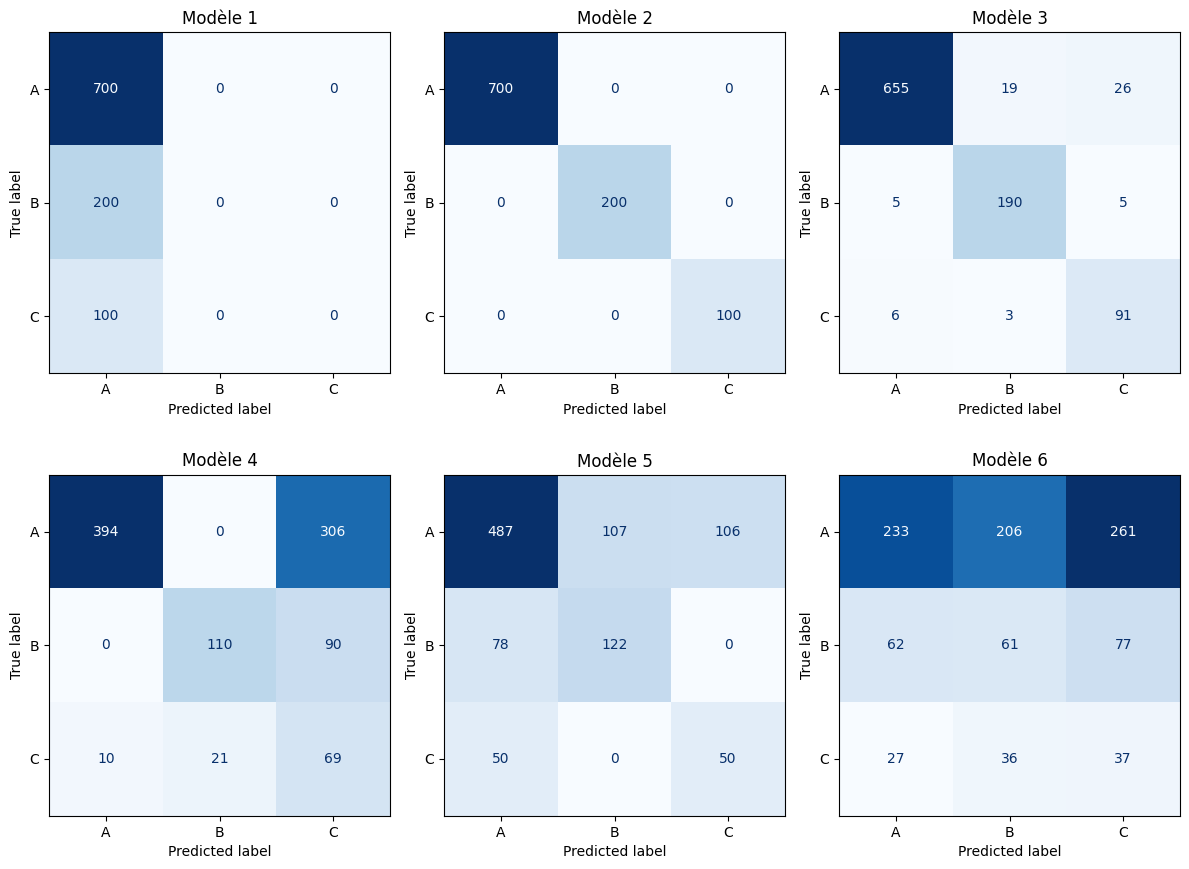

In [43]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

fig, axes = plt.subplots(2, 3, figsize=(12, 9))
labels = list(set(y_true_labels))
labels.sort()

scores_all_models = [
    scores_model_1,
    scores_model_2,
    scores_model_3,
    scores_model_4,
    scores_model_5,
    scores_model_6
]

for i, scores_model_n in enumerate(scores_all_models):
    # Pour m'assurer de faire du multi-classe, je garde la proba max
    predictions = scores_model_n == scores_model_n.max(axis=1, keepdims=True)
    cm = confusion_matrix(
        y_true_labels,
        label_binarizer.inverse_transform(predictions)
    )
    disp = ConfusionMatrixDisplay(
        confusion_matrix=cm,
        display_labels=labels
    )
    disp.plot(ax=axes.flatten()[i], cmap=plt.cm.Blues, colorbar=False)
    axes.flatten()[i].set_title(f'Modèle {i+1}')

plt.tight_layout()
plt.show()

# Remarque : si les totaux sont trop élevés, on peut toujours normaliser à 100
# le total d'observations (attention au total, pas en ligne ou en colonne !)

Lisons ensemble ces matrices de confusion pour se convaincre de leur limpidité. En ligne, nous avons les classes auxquelles appartiennent véritablement nos observations et en colonnes les prédictions de nos modèles de classification :

- pour le modèle 1 qui ne prédit que la classe A, on voit que toutes les observations ont bien été classés en A, qu'elles appartiennent en réalité à la classe A, B ou C.
- pour le modèle 2, tout est parfait (seules les cases de la diagonales sont remplies), ce qui signifie que toutes les observations de la classe A ont bien été classées en A, idem pour les observations de la classe B etc.
- pour le modèle 3, on observe quelques erreurs. Nous savons que le modèle se trompe aléatoirement quelle que soit la classe d'appartenance. Pourtant sur la matrice on l'impression que ce sont les observations de la classe A qui sont le plus souvent mal interprétées. C'est en fait une conséquence du déséquilibre de notre jeu de données, facilement identifiable grâce à la matrice de confusion. Comme il y a tout simplement plus de classes A, il y a plus de chance pour que les erreurs tombent sur la classe A, ce qui ne veut pas dire qu'elle est moins bien "comprise" par le modèle
- pour le modèle 4, on observe sans surprise que la classe C est la classe problématique (à la fois en ligne en en colonne). La colonne C nous indique que les observations classées en C par le modèle ont autant de chance d'appartenir à la classe C qu'à n'importe quelle autre classe (ne pas oublier que notre jeu de données est déséquilibré). On parle d'un problème de **précision**. Les performances à ce niveau sont à peu près celles d'un modèle aléatoire (cf modèle 6). La ligne C nous indique que la plupart des observations appartenant réellement à la classe ont été détectées comme C mais que 30% ont quand même été manquées par le modèle. On parle d'un problème de **rappel**. Remarquons que à ce niveau les performances sont meilleures que l'aléa (cf toujours modèle 6).
- pour le modèle 5, c'est exactement la même chose mais comme la classe A est plus représentée dans le jeu de données, les couleurs sont plus claires ! Remarquons que cela me semble une bonne chose, le modèle 5 commet effectivement des erreurs plus nombreuses. Quant à savoir si ces erreurs sont ou non plus graves, c'est un problème capital mais qui doit se poser en amont de l'évaluation des modèles : au moment de la collecte d'informations sur le business case et du choix du type de modèle à utiliser.
- pour le modèle 6, on a une bonne visibilité de ce que ferait un modèle complètement ivre sur notre jeu de données. Cette matrice un excellent garde fou qui nous évitera de dire par exemple que quand le modèle prédit une classe A il a plutôt raison (ce qui est vrai mais n'est absolument pas dû à la qualité du modèle).

Un moyen mnémotechnique pour ne pas se redemander à chaque fois dans quel sens on présente la matrice de confusion : on dit "vrai ou faux" et non "faux ou vrai". On commence donc par les labels réels, que l'on met à gauche de la matrice...

### 2.2 Classification report de scikit-learn

A la lumière de ces observations qui présentent l'énorme mérite de décrire complètement les résultats du modèles, intéressons-nous maintenant au rapport de classification proposé par scikit-learn. Commençons par le modèle 3, le plus classique sans doute pour bien redéfinir toutes les notions.

In [44]:
from sklearn.metrics import classification_report
predictions = scores_model_3 == scores_model_3.max(axis=1, keepdims=True)
print(classification_report(
    y_true_labels,
    label_binarizer.inverse_transform(predictions)
))

              precision    recall  f1-score   support

           A       0.98      0.94      0.96       700
           B       0.90      0.95      0.92       200
           C       0.75      0.91      0.82       100

    accuracy                           0.94      1000
   macro avg       0.88      0.93      0.90      1000
weighted avg       0.94      0.94      0.94      1000



La **précision** de la classe est définie par la proportion d'obervations appartenant véritablement à la classe A au sein des observations classées A par le modèle, soit en se référant à la matrice de confusion :

$$\text{precision}_A = \frac{AA}{\text{colonne}_A} = \frac{655}{655+5+6} \approx 98\% $$

Le **rappel** se définit comme la proportion d'observations appartenant véritablement à la classe A et détectées par le modèle, soit :

$$\text{rappel}_A = \frac{AA}{\text{ligne}_A} = \frac{655}{655+19+26} \approx 94\% $$

Quelques précisions :
- la précision et le rappel permettent de caractériser comment le modèle se comporte vis-à-vis d'une classe. On retrouve donc cette approche par aggrégation de détecteur binaire.
- précision et rappel sont d'ailleurs souvent définis sans rapport à une classe donnée dans le cadre de la classification binaire (en sous-entendant que la classe à laquelle on se réfère est la classe des positifs).
- même pour les classifications binaires, `classification_report` fera apparaître les deux classes ce qui permet de mettre en évidence d'éventuels problèmes sur la classe négative, ce que je trouve une bonne chose !
- j'insiste toutefois sur le fait qu'en réalité la connaissance de la précision positive et du rappel positif ainsi que du nombre d'obervations appartenant à chaque classe suffisent à caractériser complètement le modèle. L'information est donc redondante mais facilite sa compréhension. On observe le même phénomène sous un angle différent et on retrouve mon idée initiale d'une mesure d'adéquation d'un résultat à notre compréhension sujective et a priori d'un phénomène...
- un moyen mnémotechnique : "rappel" commence par un "r" on met donc au dénominateur la somme sur la ligne ("row")

Le **score f1** est la moyenne harmonique du rappel et de la précision :

$$\text{f1}_A = \frac{1}{\frac{1}{\text{precision}_A}+\frac{1}{\text{rappel}_A}} \approx 96\% $$

L'idée est de faire une moyenne des deux indicateurs pour ne pas injustement privilégier l'un sur l'autre. Mais très franchement son interprétation ne me semble pas triviale et entre adultes consentants je crois que l'on peut vraiment faire l'effort de regarder les deux métriques et si besoin d'en privilégier une sur l'autre en connaissance de cause. Bref, je ne m'en sers jamais. Nous verrons de plus qu'il est assez trompeur...

On remarque que scikit-learn remet les totaux du nombre d'observations par classe en ligne, ce qui est donc bien utile pour se faire une idée des proportions et des éventuels déséquilibres entre classe.

Les trois lignes du bas, sont des statistiques agrégées, qui se veulent résumer l'ensemble des classes pour avoir un nombre d'indicateur aussi réduit que possible pour un modèle donné.

Commençons par la **macro average** : il s'agit tout simplement de la moyenne arithémtqiue des colonnes. Par exemple :

$$\text{macro_average_precision} = \frac{\text{precision}_A + \text{precision}_B + \text{precision}_C}{3} \approx 88\%$$

Autant dire qu'on est en plein bricolage ! A mon avis, il ne vaut mieux pas chercher d'interprétation derrière ce genre de métrique, juste un outil pratique qu'on peut probablement avantageusement remplacer par autre chose d'un peu plus complet et de tout aussi délicat à interpréter.

Sans surprise, la **weighted average** correspond à la moyenne pondérée. Je vous fais grâce de la formule :)

Enfi, j'ai laissé de côté la première des trois dernières lignes. Historiquement, elle correspond à une autre stratégie *d'averaging*, la "micro average". En l'occurence, cette stratégie n'a absolument aucun sens (elle en aurait si on ne prenait pas en compte toutes les classes ce qui est tout à fait contraire à ce que nous essayons de faire) car elle donne le même résultat pour le rappel et la précision (et donc pour le f1 qui est rappelons-le la moyenne des 2). Scikit-learn a donc avantageusement remplacé la dénomination par **accuracy** et ne l'a fait apparaître qu'une fois. L'accuracy (j'ai longtemps cru qu'il s'agissait d'un synonyme pour précision mais pas du tout!) correspond à la proportion d'observation bien classées sur l'ensemble des observations. Ici, en notant $N$ le nombre total d'observations, on a

$$\text{accuracy} = \frac{AA + BB + CC}{N} = 94\%$$

Pour le coup, cette métrique cache des choses mais elle a indubitablement un sens !

Pour fixer, les idées, voici maintenant les rapports de classification de tous nos modèles. Je laisse au lecteur le plaisir feint de parcourir lesdits rapports et de se demander si les chiffres qui y figurent reflètent ou non ce qu'il sait de la réalité des modèles concernés ;)


In [45]:
for i, scores_model_n in enumerate(scores_all_models):
    predictions = scores_model_n == scores_model_n.max(axis=1, keepdims=True)
    print(f'Modèle {i+1}')
    print(classification_report(
        y_true_labels,
        label_binarizer.inverse_transform(predictions)
    ))
    print("-"*53 + "\n")

Modèle 1
              precision    recall  f1-score   support

           A       0.70      1.00      0.82       700
           B       0.00      0.00      0.00       200
           C       0.00      0.00      0.00       100

    accuracy                           0.70      1000
   macro avg       0.23      0.33      0.27      1000
weighted avg       0.49      0.70      0.58      1000

-----------------------------------------------------

Modèle 2
              precision    recall  f1-score   support

           A       1.00      1.00      1.00       700
           B       1.00      1.00      1.00       200
           C       1.00      1.00      1.00       100

    accuracy                           1.00      1000
   macro avg       1.00      1.00      1.00      1000
weighted avg       1.00      1.00      1.00      1000

-----------------------------------------------------

Modèle 3
              precision    recall  f1-score   support

           A       0.98      0.94      0.96   

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### 2.3 Le MCC ou Matthews correlation coefficient

Il s'agit d'une autré métrique synthétique pour caractériser les performances d'un modèle de classification, dont il me semble intérssant de faire mention ici. C'est un indicateur considéré comme meilleur notamment que le score f1 notamment dans le cadre de jeux de données déséquilibrés. C'est en tout cas la thèse de Davide Chicco dans son article *Ten quick tips for machine learning in computational biology* cité en bibliographie (je crois que d'autres chercheurs ont cependant nuancé son affirmation). Je laisse au lecteur intéressé le soin de découvrir la définition sur le user guide de scikit-learn. Retenons simplement que :
- il s'agit d'un coefficient de corrélation dont la généralisation aux modèles multiclasses me semble plus satisfaisante que les moyennes évoquées plus haut
- il est compris en -1 et 1, 1 étant la valeur parfaite et 0 la valeur aléatoire

Dans son "Tip n°8" D. Chicco vante les mérites du MCC, notamment sur le score f1. Voyant ce qu'il en est pour notre jeu de données :

- mais on voyait déjà avec les matrices de confusion ! et plus précis car modèle stupide meilleur que aléatoire.

In [47]:
from sklearn.metrics import matthews_corrcoef
for i, scores_model_n in enumerate(scores_all_models):
  predictions = scores_model_n == scores_model_n.max(axis=1, keepdims=True)
  mcc = matthews_corrcoef(
      y_true_labels,
        label_binarizer.inverse_transform(predictions)
  )
  print(f"Modèle {i+1} - MCC : {round(mcc, 2)}")

Modèle 1 - MCC : 0.0
Modèle 2 - MCC : 1.0
Modèle 3 - MCC : 0.87
Modèle 4 - MCC : 0.41
Modèle 5 - MCC : 0.33
Modèle 6 - MCC : 0.01


D. Chicco fait remarquer que dans le cas d'un jeu de données **déséquilibré** (pour nous la classe A largement sur-représentée), on peut penser avec une métrique comme le score f1 qu'un modèle qui se contente de prédire la variable la plus présente est un bon modèle. C'est juste : le score f1 de la classe A pour notre modèle 1 est finalement relativement élevé (nettement plus haut que celui des modèles 5 et 6). Impossible par contre de penser que le modèle 1 est un bon modèle avec le MCC, puiqu'il se voit affublé d'un 0 pointé. Le modèle ne ferait pas mieux qu'un modèle aléatoire. Ou plus exactement il ne serait **pas du tout corrélé** à la valeur qu'il essaie de prédire.

En ce qui me concerne, je reste profondément convaincu que  cet argument vient plutôt discréditer le f1 (ce dont je me réjouis) que conforter le MCC. De fait, avec nos matrices de confusion (ou à la limite nos rapports de classification détaillés par classe), on arrive aux même conclusions que D. Chicco avec son MCC. Ou plutôt non, on arrive à des conclusions bien plus précises :
- grâce au benchmark du modèle aléatoire que j'encourage à faire systématiquement, on voit assez immédiatement que le modèle 1 a un problème de taille : dans la matrice de confusion, on voit instantanément que l'output est systématiquement "A" et dans le rapport de classification on voit que le **modèle 1 a la même précision sur la classe A que le modèle aléatoire**
- dire cela me semble en fait plus précis que l'examen du MCC (qui ne coûte rien et que l'on peut toujours faire malgré tout :) car en vérité le modèle 1 est me semble un peu moins stupide que le modèle 6 ! En tout cas différent, ce que l'on voit bien en lisant les rappels (largement meilleur évidemment sur A mais nuls B et C)...

*Remarque* : pour suivre plus rigoureusement le raisonnement de l'article de D. Chicco, il faudrait comparer des modèles de classification binaire mais je crois que ma conclusion resterait inchangée.

Disons pour conclure sur le MCC et pour ne pas me faire dire ce que je n'ai pas écrit qu'il s'agit sans doute malgré de l'une des **moins mauvaises métriques synthétisant les performances d'un modèle en un seul nombre**.

## 3. Metriques faisant appel aux scores

Jusqu'à présent nous n'avons examiné que des métriques reposant sur les labels prédits et non sur les scores alors que de très nombreux modèles sont construits autour de l'idée de minimiser une distance calculée avec des outputs continus que l'on appelle score. C'est donc une information qu'il convient sans doute parfois d'exploiter ! C'est même une information qui peut avoir une importance capitale : un modèle mal calibré peut être excellent tout en donnant l'impression qu'il ne répond pas au problème que l'on se pose alors qu'il suffirait d'ajuster un simple seuil... Il peut donc être très intéressant de comparer des modèles en amont de leur calibration, avec des métriques qui reposent sur les outputs qui ont véritablement servis à l'entraînement...

### 3.1 Utiliser la métrique sur laquelle le modèle est entraîné

Et oui, on en revient aux basiques mais si le machine learning est ce qu'il est aujourd'hui c'est quand même uniquement parce que l'on minimise des erreurs. Donc il n'est pas impossible que les fonctions d'erreurs en question aient parfois une réelle valeur, surtout si le modèle est bien choisi et la fonction d'erreur adapté (bien évidement d'autres considérations telles que la dérivabilité rentrent en considération). Supposons que nos modèles soient des régressions logistiques ou des réseaux de neurones, on calculera par exemple la log-loss :
$$ - \frac{1}{N} \sum_{i=1}^{N} \sum_{k=1}^{K}y_{i,k}\log(p_{i,k}) $$

avec
- $N$ le nombre d'observations
- $K$ le nombre de classes
- $y_{i,k}$ valabt 1 si le modèle output un la classe $k$ pour l'observation $i$ et 0 sinon
- $p_{i,k}$ le score associé à l'observation $i$ et la classe $k$ (on rappelle que comme dans les exemples donnés en début de notebook, les scores donnés par un modèle se présente sous la forme d'une matrice de coefficients avec autant de lignes que d'observations et autant de colonnes que de classes - et même a priori une somme sur chaque ligne égale à 1 ce qui n'est pas le cas pour nous)

In [49]:
from sklearn.metrics import log_loss

for i, scores_model_n in enumerate(scores_all_models):
  loss = log_loss(y_true_labels, scores_model_n)
  print(f"Modèle {i+1} - MCC : {round(loss, 2)}")

Modèle 1 - MCC : 0.97
Modèle 2 - MCC : 0.62
Modèle 3 - MCC : 0.69
Modèle 4 - MCC : 0.83
Modèle 5 - MCC : 0.87
Modèle 6 - MCC : 1.33


Cette métrique a évidemment des inconvénients : le logarithme va par exemple pénaliser fortement les fausses prédictions très confiantes (en même temps il est important de l'avoir en tête puisque c'est quand même ce que l'on demande de faire à nos modèles quand on utlise cette fonction de perte). Mais globalement, je trouve les résultats assez intuitifs (non interprétables cependant). Le modèle 6 est clairement le plus mauvais. Le modèle 2 est le meilleur mais ses scores ne sont en fait pas parfaits au sens de la logloss. Il est suivi de près par le 3. Et les modèles 4 et 5 sont à mettre dans le même panier (malgré le déséquilibre des classes).

### 3.2 Courbes ROC et Precision-Rappel

Enfin on peut essayer d'interpréter les scores au moyen de courbes ROC ou précision-rappel. Cette approche classique en classification binaire est transposable à la classification multiclasse. Concentrons-nous ici sur les stratégies appelées One versus the Rest, qui reprennent notre idée initiale de se ramener à un ensemble d'indicateurs binaires.

Personnellement, je préfère l'approche qui consiste, commme pour les rapports de classification, à tracer autant de courbes qu'il y a de classes. Cela me semble plus précis et plus interprétable (et offre à la rigueur la possibilité de choisir des seuils dépendants de la classe ?).

Il existe également des stratégies de moyenne. Le macro averaging qui consiste à calculer la moyenne (pondérée ou non) de toutes les courbes pour n'en tracer qu'une seule. Le micro-averaging qui prend ici son sens et qui consiste à réduire la matrice de scores à un vecteur de dimension 1 et de taille $kN$ toujours avec $N$ le nombre d'observations et $k$ le nombre de classes. On voit ici que l'on peut faire varier un seuil et obtenir des couples precision/rappel ou fpr/tpr pour les courbes ROC. La classe positive devient alors une sorte classe "des biens classés". Par contre, je ne vois pas comment on pourrait formuler la notion de précision par exemple dès lors que l'on a procédé à cette observation puisque toutes les classes sont mélangées et que le seuil n'a plus de sens... cf [cet article scikit-learn](https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html#example-model-selection-plot-roc-py) pour plus de détails.



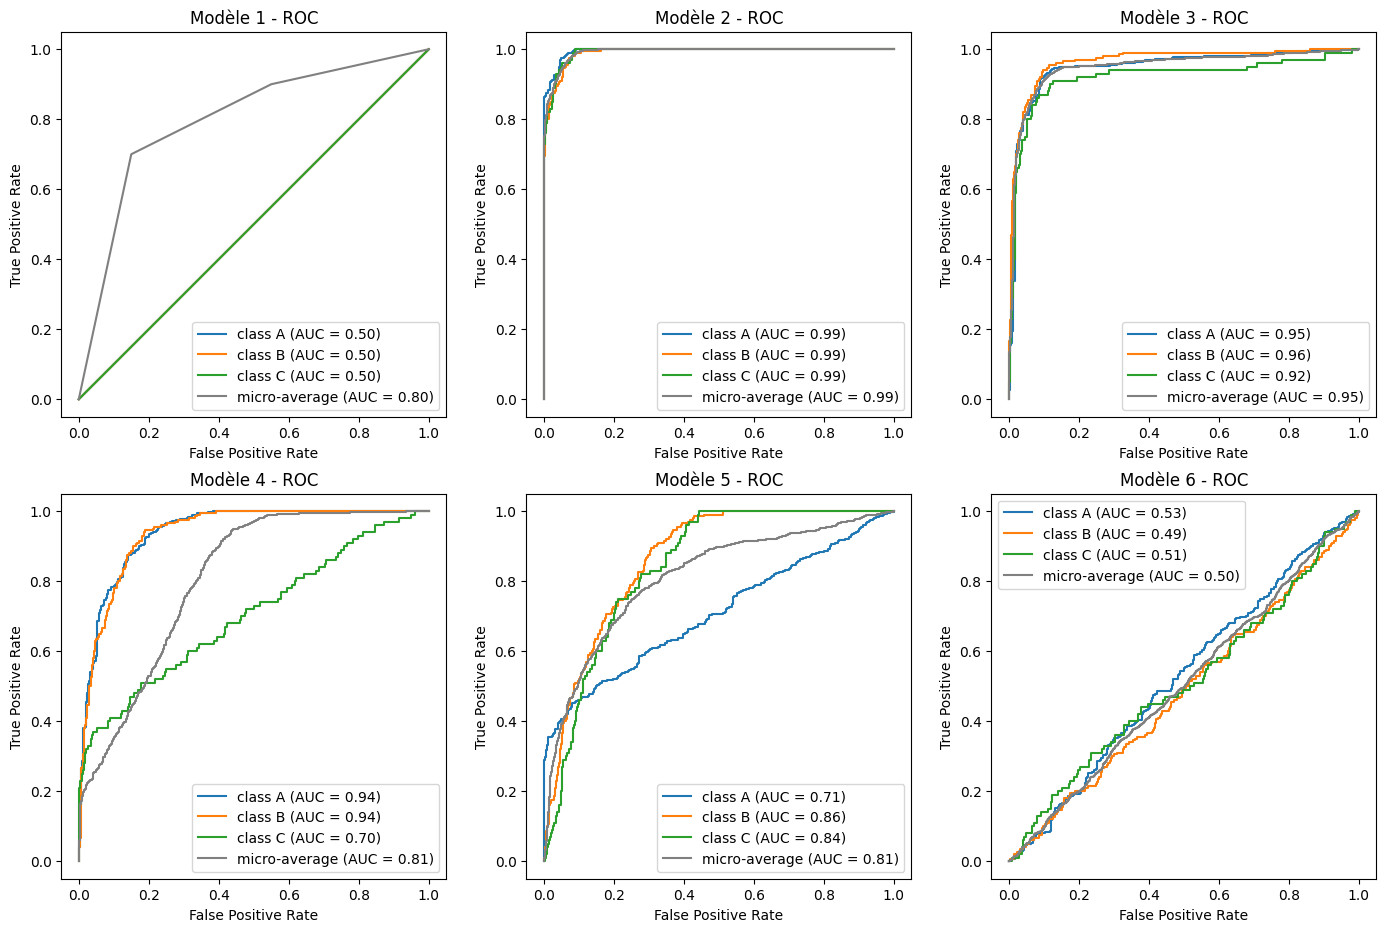

In [86]:
from sklearn.metrics import auc, roc_curve
from sklearn.metrics import RocCurveDisplay

fig, axes = plt.subplots(2, 3, figsize=(17, 11))


def plot_all_roc(ax, scores_model_n, model_n):

  fpr, tpr, roc_auc = {}, {}, {}

  for i in range(len(labels)):
      fpr[i], tpr[i], _ = roc_curve(y_true[:, i], scores_model_n[:, i])
      roc_auc[i] = auc(fpr[i], tpr[i])

  fpr["micro"], tpr["micro"], _ = roc_curve(
      y_true.ravel(),
      scores_model_n.ravel()
  )
  roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

  for i, label in enumerate(labels):
      RocCurveDisplay.from_predictions(
          y_true[:, i],
          scores_model_n[:, i],
          name=f"class {label}",
          ax=ax,
      )
  ax.plot(
      fpr["micro"],
      tpr["micro"],
      label=f"micro-average (AUC = {roc_auc['micro']:.2f})",
      color="grey",
  )

  ax.axis("square")
  ax.set_xlabel("False Positive Rate")
  ax.set_ylabel("True Positive Rate")
  ax.set_title(f"Modèle {model_n+1} - ROC")
  ax.legend()

for i, scores_model_n in enumerate(scores_all_models):
  plot_all_roc(axes.ravel()[i], scores_model_n, i)

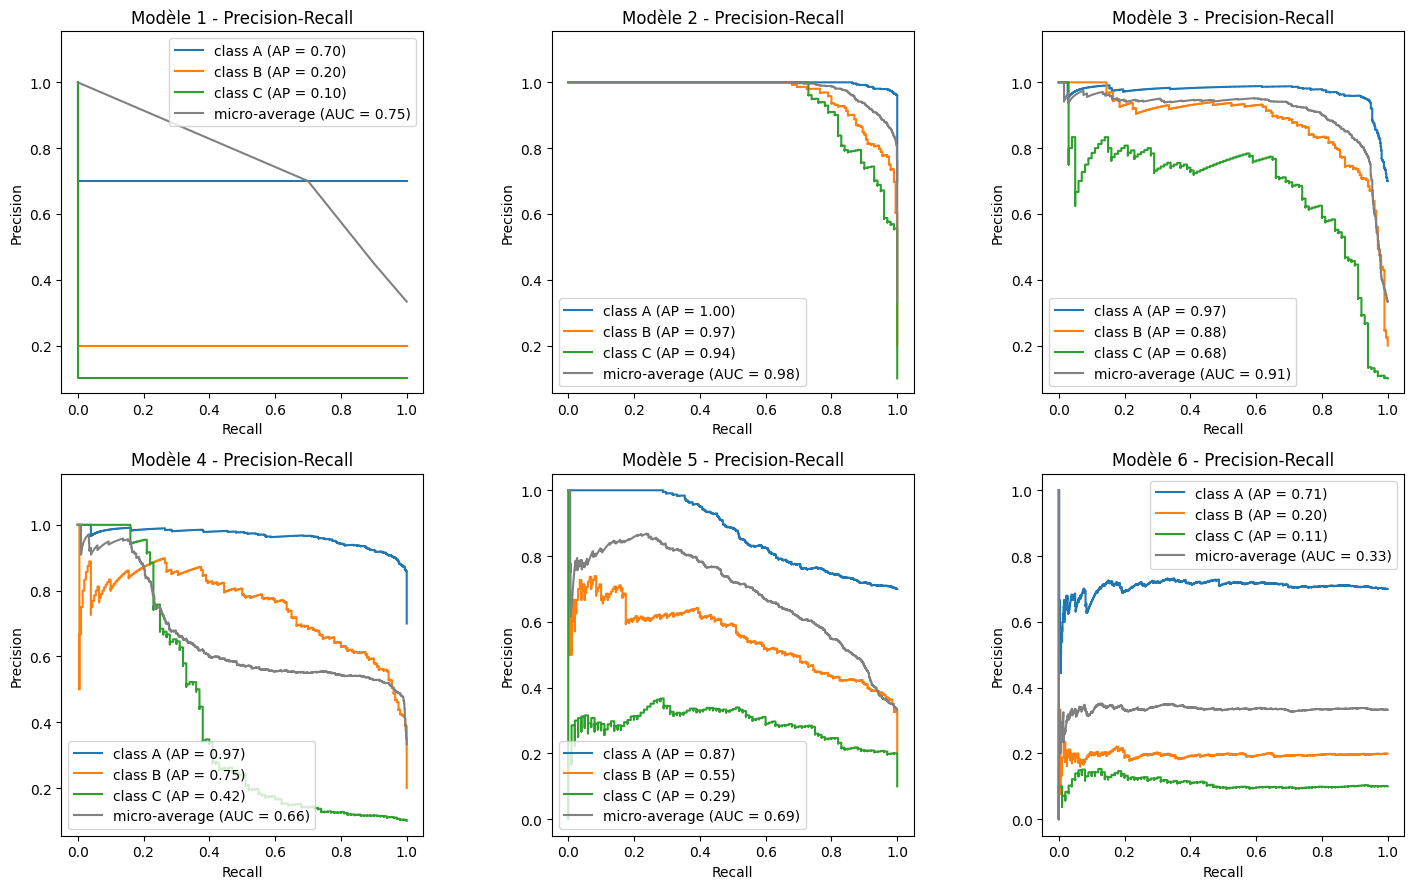

In [84]:
from sklearn.metrics import precision_recall_curve, auc, PrecisionRecallDisplay

fig, axes = plt.subplots(2, 3, figsize=(15, 9))

def plot_all_precision_recall(ax, scores_model_n, model_n):

    precision, recall, pr_auc = {}, {}, {}

    for i in range(len(labels)):
        precision[i], recall[i], _ = precision_recall_curve(
            y_true[:, i],
            scores_model_n[:, i]
        )
        pr_auc[i] = auc(recall[i], precision[i])

    precision["micro"], recall["micro"], _ = precision_recall_curve(y_true.ravel(), scores_model_n.ravel())
    pr_auc["micro"] = auc(recall["micro"], precision["micro"])

    for i, label in enumerate(labels):
        PrecisionRecallDisplay.from_predictions(
            y_true[:, i],
            scores_model_n[:, i],
            name=f"class {label}",
            ax=ax,
        )

    ax.plot(
        recall["micro"],
        precision["micro"],
        label=f"micro-average (AUC = {pr_auc['micro']:.2f})",
        color="grey",
    )

    ax.axis("square")
    ax.set_xlabel("Recall")
    ax.set_ylabel("Precision")
    ax.set_title(f"Modèle {model_n+1} - Precision-Recall")
    ax.legend()

for i, scores_model_n in enumerate(scores_all_models):
    plot_all_precision_recall(axes.ravel()[i], scores_model_n, i)

plt.tight_layout()

Alors là évidemment les concepts sont beaux mais la lecture des graphiques est ardue... On remarquera tout de même plusieurs choses :
- l'approche one versus all conviendrait en fait beaucoup mieux à de la classification multilabel que multiclasse. On voit notamment sur les courbes de precision rappel que les valeurs obtenues ne sont pas les mêmes que celles des rapports de classification. Cela est dû au fait que pour labelliser on prend le max de la proba alors que la courbe precision-rappel est à voir dans une optique de détecteur
- on retouve bien les formes atttendues pour de le modèle aléatoire
- les courbes roc micro-averagees ne font pas de distinction entre les modèles 4 et 5 alors que les courbes precision-rappel en font une, comme quoi les métriques ne sont vraiment pas équivalentes
- les courbes ROC permettent d'dientifier beaucoup plus vite la façon dont nous avons généré nos erreurs pour les modèles 4 et 5, ce qui n'est pas du tout le cas des courbes precision-recall (même si en comparant avec le modèle aléatoire on parvient aux mêmes conclusions)
- dans notre cas, je préfère la lecture des courbes ROC (même si d'un point de vue métier les seuils seront souvent fixés en classification binaire à la lecture des courbes de precision-rappel) qui me paraissent somme toute moins sensible au déséquilibrage des classes : pour le modèle 5, la courbe bleue est au dessous des autres...

## Conclusion

Un mot de conclusion pour souligner le fait que l'on peut distinguer deux processus somme toute très différents au cours desquels on sera amené à utiliser des métriques de performance :
- juger de la **qualité d'un modèle dans l'absolu** : j'espère que le lecteur est désormais convaincu que ce ne peut être le rôle exclusif de métriques, sans une compréhension humaine du problème. C'est un problème ouvert qui nécessite je pense plus de moyens et plus de temps
- **comparer la qualité de plusieurs modèles** dans le cadre de la **conception** d'un projet (on cherche à sélectionner le meilleur algorithme pour la tâche à accomplir) ou dans le cadre d'un **réentraînement** réguliler d'un modèle déjà en production. Ce problème n'est pas trivial non plus mais les métriques que nous avons présentées aident incontestablement à le résoudre. Quelques lignes de conduite :
  - **ne pas se reposer aveuglément sur une unique métrique** même s'il s'agit du MCC
  - car un modèle n'est indubitablement meilleur qu'un autre que s'il **performe mieux sur toutes les lignes et toutes les colonnes de la matrice de confusion** (pas si son MCC est supérieur)
  - si tel est le cas, c'est génial notamment dans le cadre d'un réapprentissage automatique (pas dans le cas d'une conception de modèle puisque le modèle 1 est invincible à ce petit jeu)
  - si tel n'est pas le cas, on essaierai d'utilier une combinaison pragmatique de différentes métriques. Par exemple, on peut se dire qu'un modèle est meilleur qu'un autre si sa logloss est plus petite que la précision sur telle classe et supérieur et que le rappel et la précision des autres n'est pas inférieure de plus de $x$ points...